# Profit & Lost Calculations

In [2]:
import sys
sys.path.append('../Functions/')

from ProfitLost import ProfitLost
pl = ProfitLost()

import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
import eikon as ek
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_weights = pd.read_csv('../../Data/Weigths_OEX_PCA.csv',index_col=0)
securities = df_weights.index.tolist()
securities +=['SPX']
weights = df_weights.coef.tolist()
weights += [1]
weights = pd.DataFrame({'ticker':securities, 'weights':weights})
weights

ticker  weights
0     GS   0.0788
1    UNP   0.0469
2    LIN   0.1240
3    BLK   0.1582
4    MCD   0.0803
5      V   0.1354
6     MA   0.0783
7  CMCSA   0.1110
8    SPX   1.0000

In [3]:
enter = pd.read_csv('../../Data/signals/Entery_Signal.csv', index_col=0)
enter.index=pd.to_datetime(enter.index)
enter.head(5)

trade
Date             
2019-02-13  Short
2019-02-20  Short
2019-02-22  Short
2019-02-28  Short
2019-03-01  Short

In [4]:
price_oex = pd.read_csv('../../Data/Price/price_oex.csv',index_col=0)
price_oex.index=pd.to_datetime(price_oex.index)
price_oex.head(5)

HIGH    CLOSE      LOW     OPEN  VOLUME
Date                                                  
2018-07-02  1199.76  1199.46  1185.61  1188.68     NaN
2018-07-03  1203.41  1191.76  1191.01  1202.10     NaN
2018-07-05  1203.24  1202.53  1193.24  1196.56     NaN
2018-07-06  1215.49  1213.34  1201.23  1203.37     NaN
2018-07-09  1225.14  1224.88  1217.46  1217.46     NaN

In [5]:
price_spx = pd.read_csv('../../Data/Price/price_spx.csv',index_col=0)
price_spx.index=pd.to_datetime(price_spx.index,infer_datetime_format=True)
price_spx.head(5)

CLOSE
Date               
2018-06-19  2762.59
2018-06-20  2767.32
2018-06-21  2749.76
2018-06-22  2754.88
2018-06-25  2717.07

In [6]:
price_constituents = pd.read_csv('../../Data/Price/constituents_oex_cleansed.csv',index_col=0)
price_constituents.index=pd.to_datetime(price_constituents.index)
price_constituents

XOM          GD         ABT        COST         CVX  \
Date                                                                    
2018-06-19  65.109734  172.837708   58.503422  195.824524  105.307610   
2018-06-20  64.908028  173.481232   58.315723  196.249100  105.097885   
2018-06-21  64.294846  170.789261   57.949730  198.117447  102.833038   
2018-06-22  65.658363  171.650314   58.128040  199.193161  104.938522   
2018-06-25  64.335213  171.396545   57.030037  199.806458  102.849815   
...               ...         ...         ...         ...         ...   
2022-02-08  79.379997  213.337646  128.139267  521.150024  135.022400   
2022-02-09  79.000000  214.312515  129.971970  528.830017  136.358353   
2022-02-10  78.239998  210.413040  127.252808  518.479980  134.626541   
2022-02-11  80.209999  212.641296  124.991814  509.670013  137.367767   
2022-02-14  78.980003  210.064865  122.292572  506.559998  135.250000   

                  KHC          HD         BLK        AVGO       MDLZ  ...  \
Date                                                                  ...   
2018-06-19  51.793964  182.436050  478.575073  227.699509  36.944237  ...   
2018-06-20  52.544117  182.316986  478.547913  227.935104  37.328888  ...   
2018-06-21  52.152370  183.443405  477.093903  226.565109  37.310562  ...   
2018-06-22  52.685810  180.787598  475.058167  226.617477  37.823425  ...   
2018-06-25  52.777500  179.844330  468.151428  220.256378  37.960812  ...   
...               ...         ...         ...         ...        ...  ...   
2022-02-08  34.573944  359.271851  802.049072  596.188416  67.672310  ...   
2022-02-09  34.583839  362.184296  807.621948  607.233765  67.582802  ...   
2022-02-10  33.930756  352.959961  773.042236  587.387939  66.399406  ...   
2022-02-11  34.366142  348.188751  767.379944  569.568420  66.329796  ...   
2022-02-14  34.227612  349.451111  755.280518  574.693848  65.772903  ...   

                   LMT         VZ        TSLA        ABBV         DD  \
Date                                                                   
2018-06-19  273.444183  40.704830   70.510002   80.622459  87.706451   
2018-06-20  273.751434  40.360722   72.444000   80.819885  87.085251   
2018-06-21  271.509888  40.813931   69.501999   78.598885  86.279045   
2018-06-22  270.605988  41.762306   66.725998   76.904343  88.552315   
2018-06-25  270.054565  41.628029   66.601997   76.542381  87.204216   
...                ...        ...         ...         ...        ...   
2022-02-08  393.331970  52.184570  922.000000  142.300568  79.780083   
2022-02-09  391.842224  52.856392  932.000000  141.993195  81.134148   
2022-02-10  382.794495  52.401928  904.549988  141.507324  79.979218   
2022-02-11  393.480927  52.678558  860.000000  140.813217  78.933800   
2022-02-14  384.323975  52.629158  875.760010  141.794876  78.973625   

                 GILD        EXC         MCD        AAPL         LLY  
Date                                                                  
2018-06-19  61.169609  26.168941  150.914978   44.695324   80.795158  
2018-06-20  61.617981  26.288433  148.710312   44.890289   80.292625  
2018-06-21  61.669701  26.055737  146.853241   44.639965   80.097206  
2018-06-22  61.281693  26.099760  150.530762   44.509983   79.957626  
2018-06-25  61.342068  26.319881  146.194611   43.848064   79.818016  
...               ...        ...         ...         ...         ...  
2022-02-08  62.898258  42.665089  258.641174  174.830002  238.912674  
2022-02-09  62.582287  42.248550  258.422394  176.279999  242.258698  
2022-02-10  61.012299  41.693172  255.448959  172.119995  238.643784  
2022-02-11  61.288773  41.782433  253.748428  168.639999  234.760010  
2022-02-14  60.340855  41.851852  251.988205  168.880005  234.690002  

[922 rows x 99 columns]

In [7]:
df_price=price_constituents
df_price['SPX']=price_spx.CLOSE
df_price=df_price.dropna()
df_price.head(5)

XOM          GD        ABT        COST         CVX  \
Date                                                                   
2018-06-19  65.109734  172.837708  58.503422  195.824524  105.307610   
2018-06-20  64.908028  173.481232  58.315723  196.249100  105.097885   
2018-06-21  64.294846  170.789261  57.949730  198.117447  102.833038   
2018-06-22  65.658363  171.650314  58.128040  199.193161  104.938522   
2018-06-25  64.335213  171.396545  57.030037  199.806458  102.849815   

                  KHC          HD         BLK        AVGO       MDLZ  ...  \
Date                                                                  ...   
2018-06-19  51.793964  182.436050  478.575073  227.699509  36.944237  ...   
2018-06-20  52.544117  182.316986  478.547913  227.935104  37.328888  ...   
2018-06-21  52.152370  183.443405  477.093903  226.565109  37.310562  ...   
2018-06-22  52.685810  180.787598  475.058167  226.617477  37.823425  ...   
2018-06-25  52.777500  179.844330  468.151428  220.256378  37.960812  ...   

                   VZ       TSLA       ABBV         DD       GILD        EXC  \
Date                                                                           
2018-06-19  40.704830  70.510002  80.622459  87.706451  61.169609  26.168941   
2018-06-20  40.360722  72.444000  80.819885  87.085251  61.617981  26.288433   
2018-06-21  40.813931  69.501999  78.598885  86.279045  61.669701  26.055737   
2018-06-22  41.762306  66.725998  76.904343  88.552315  61.281693  26.099760   
2018-06-25  41.628029  66.601997  76.542381  87.204216  61.342068  26.319881   

                   MCD       AAPL        LLY      SPX  
Date                                                   
2018-06-19  150.914978  44.695324  80.795158  2762.59  
2018-06-20  148.710312  44.890289  80.292625  2767.32  
2018-06-21  146.853241  44.639965  80.097206  2749.76  
2018-06-22  150.530762  44.509983  79.957626  2754.88  
2018-06-25  146.194611  43.848064  79.818016  2717.07  

[5 rows x 100 columns]

In [8]:
option_data = pd.read_csv('../../Data/Option_price/options_data.csv')
option_data.date = pd.to_datetime(option_data.date, format="%Y%m%d")
option_data.exdate = pd.to_datetime(option_data.exdate, format="%Y%m%d")
option_data.head(5)

secid       date             symbol  symbol_flag     exdate  last_date  \
0  102235 2018-01-02  BLK 180119C180000            1 2018-01-19        NaN   
1  102235 2018-01-02  BLK 180119C185000            1 2018-01-19        NaN   
2  102235 2018-01-02  BLK 180119C190000            1 2018-01-19        NaN   
3  102235 2018-01-02  BLK 180119C195000            1 2018-01-19        NaN   
4  102235 2018-01-02  BLK 180119C200000            1 2018-01-19        NaN   

  cp_flag  strike_price  best_bid  best_offer  volume  impl_volatility  \
0       C        180000     327.2       331.1       0         1.644338   
1       C        185000     322.2       326.2       0         1.702836   
2       C        190000     316.9       320.9       0              NaN   
3       C        195000     312.1       316.1       0              NaN   
4       C        200000     306.9       311.2       0              NaN   

      delta     gamma      vega      theta   optionid  index_flag  \
0  0.999063  0.000018  0.349381  -8.915142  112567840           0   
1  0.998364  0.000028  0.581592 -13.457080  112567841           0   
2       NaN       NaN       NaN        NaN  112567842           0   
3       NaN       NaN       NaN        NaN  112567843           0   
4       NaN       NaN       NaN        NaN  112567844           0   

           issuer exercise_style  
0  BLACKROCK INC.              A  
1  BLACKROCK INC.              A  
2  BLACKROCK INC.              A  
3  BLACKROCK INC.              A  
4  BLACKROCK INC.              A

In [9]:
option_data_spx = pd.read_csv('../../Data/Option_price/spx_options.csv')
option_data_spx.date = pd.to_datetime(option_data_spx.date, format="%Y%m%d")
option_data_spx.exdate = pd.to_datetime(option_data_spx.exdate, format="%Y%m%d")

In [10]:
option_data = option_data.append(option_data_spx)
del option_data_spx
option_data.head(5)

secid       date             symbol  symbol_flag     exdate  last_date  \
0  102235 2018-01-02  BLK 180119C180000            1 2018-01-19        NaN   
1  102235 2018-01-02  BLK 180119C185000            1 2018-01-19        NaN   
2  102235 2018-01-02  BLK 180119C190000            1 2018-01-19        NaN   
3  102235 2018-01-02  BLK 180119C195000            1 2018-01-19        NaN   
4  102235 2018-01-02  BLK 180119C200000            1 2018-01-19        NaN   

  cp_flag  strike_price  best_bid  best_offer  volume  impl_volatility  \
0       C        180000     327.2       331.1     0.0         1.644338   
1       C        185000     322.2       326.2     0.0         1.702836   
2       C        190000     316.9       320.9     0.0              NaN   
3       C        195000     312.1       316.1     0.0              NaN   
4       C        200000     306.9       311.2     0.0              NaN   

      delta     gamma      vega      theta   optionid  index_flag  \
0  0.999063  0.000018  0.349381  -8.915142  112567840           0   
1  0.998364  0.000028  0.581592 -13.457080  112567841           0   
2       NaN       NaN       NaN        NaN  112567842           0   
3       NaN       NaN       NaN        NaN  112567843           0   
4       NaN       NaN       NaN        NaN  112567844           0   

           issuer exercise_style  
0  BLACKROCK INC.              A  
1  BLACKROCK INC.              A  
2  BLACKROCK INC.              A  
3  BLACKROCK INC.              A  
4  BLACKROCK INC.              A

Create a column with ticker in order 

In [11]:
list_symbols = df_weights.index.tolist()
list_symbols += ['SPX']
list_symbols

['GS', 'UNP', 'LIN', 'BLK', 'MCD', 'V', 'MA', 'CMCSA', 'SPX']

In [12]:
option_data.symbol.head(5)

0    BLK 180119C180000
1    BLK 180119C185000
2    BLK 180119C190000
3    BLK 180119C195000
4    BLK 180119C200000
Name: symbol, dtype: object

In [13]:
option_data['ticker']=[x.split(' ')[0] for x in option_data.symbol]
option_data.ticker.unique()

array(['BLK', 'CMCSA', 'GS', 'MCD', 'PX', 'LIN', 'OEX', 'UNP', 'MA', 'V',
       'SPX', 'SPXW'], dtype=object)

In [14]:
option_data.loc[option_data['ticker']=='SPXW','ticker'] = 'SPX'

In [15]:
enter.index=pd.to_datetime(enter.index, unit='D')
enter.index = enter.index.tz_localize(None)
enter

trade
Date             
2019-02-13  Short
2019-02-20  Short
2019-02-22  Short
2019-02-28  Short
2019-03-01  Short
...           ...
2021-11-04  Short
2021-11-05  Short
2021-11-09  Short
2021-11-15  Short
2021-11-19  Short

[162 rows x 1 columns]

In [16]:
enter_dis=pd.read_csv('../../data/signals/entry_signal_dispersion.csv',index_col=0)
enter_dis.index=pd.to_datetime(enter_dis.index)
enter_dis.index = enter_dis.index.tz_localize(None)
enter_dis

trade
Date             
2019-02-13  Short
2019-02-14  Short
2019-03-06  Short
2019-03-07  Short
2019-03-08  Short
...           ...
2021-11-19   Long
2021-11-22   Long
2021-11-23  Short
2021-11-26   Long
2021-12-01  Short

[322 rows x 1 columns]

In [17]:
enter_pair=pd.read_csv('../../data/signals/pairwise_entry.csv',index_col=0)
enter_pair.index=pd.to_datetime(enter_pair.index)
enter_pair.index = enter_pair.index.tz_localize(None)
enter_pair

trade
Date             
2018-09-12  Short
2018-09-13  Short
2018-09-14  Short
2018-09-17  Short
2018-09-18  Short
...           ...
2022-01-24  Short
2022-01-25  Short
2022-02-10   Long
2022-02-11   Long
2022-02-14   Long

[329 rows x 1 columns]

# PnL

Cleansing df_portfolio

## Dispersion

In [18]:
date_lower_bound=20
date_higher_bound=500
trade_book_straddle_dis=pl.trade_book_straddle(enter_dis, option_data, df_weights, df_price,date_lower_bound, date_higher_bound,list_symbols)
trade_book_straddle_dis

Entry moment, 2019-02-13 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=-1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(72, 24)
Entry moment, 2019-02-14 00:00:00
(72, 24)
Entry moment, 2019-03-06 00:00:00
(72, 24)
Entry moment, 2019-03-07 00:00:00
(74, 24)
Entry moment, 2019-03-08 00:00:00
(74, 24)
Entry moment, 2019-03-19 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

(72, 24)
Entry moment, 2019-03-20 00:00:00
(72, 24)
Entry moment, 2019-03-21 00:00:00
(74, 24)
Entry moment, 2019-03-22 00:00:00
(74, 24)
Entry moment, 2019-03-25 00:00:00
(72, 24)
Entry moment, 2019-03-26 00:00:00
(72, 24)
Entry moment, 2019-03-27 00:00:00
(72, 24)
Entry moment, 2019-03-28 00:00:00
(72, 24)
Entry moment, 2019-03-29 00:00:00
(72, 24)
Entry moment, 2019-04-01 00:00:00
(70, 24)
Entry moment, 2019-04-02 00:00:00
(70, 24)
Entry moment, 2019-04-03 00:00:00
(70, 24)
Entry moment, 2019-04-04 00:00:00
(72, 24)
Entry moment, 2019-04-05 00:00:00
(72, 24)
Entry moment, 2019-04-08 00:00:00
(66, 24)
Entry moment, 2019-04-09 00:00:00
(68, 24)
Entry moment, 2019-04-10 00:00:00
(68, 24)
Entry moment, 2019-04-11 00:00:00
(70, 24)
Entry moment, 2019-04-12 00:00:00
(70, 24)
Entry moment, 2019-04-15 00:00:00
(68, 24)
Entry moment, 2019-04-30 00:00:00
(70, 24)
Entry moment, 2019-05-01 00:00:00
(72, 24)
Entry moment, 2019-05-02 00:00:00
(74, 24)
Entry moment, 2019-05-03 00:00:00
(74, 24)
En

(70, 24)
Entry moment, 2020-08-26 00:00:00
(70, 24)
Entry moment, 2020-09-03 00:00:00
(72, 24)
Entry moment, 2020-09-04 00:00:00
(72, 24)
Entry moment, 2020-09-08 00:00:00
(68, 24)
Entry moment, 2020-09-09 00:00:00
(68, 24)
Entry moment, 2020-09-10 00:00:00
(70, 24)
Entry moment, 2020-09-11 00:00:00
(70, 24)
Entry moment, 2020-09-14 00:00:00
(68, 24)
Entry moment, 2020-09-15 00:00:00
(68, 24)
Entry moment, 2020-10-06 00:00:00
(64, 24)
Entry moment, 2020-10-09 00:00:00
(66, 24)
Entry moment, 2020-10-12 00:00:00
(64, 24)
Entry moment, 2020-10-16 00:00:00
(68, 24)
Entry moment, 2020-10-19 00:00:00
(66, 24)
Entry moment, 2020-10-20 00:00:00
(66, 24)
Entry moment, 2020-10-21 00:00:00
(66, 24)
Entry moment, 2020-10-23 00:00:00
(68, 24)
Entry moment, 2020-10-26 00:00:00
(66, 24)
Entry moment, 2020-10-27 00:00:00
(66, 24)
Entry moment, 2020-10-28 00:00:00
(66, 24)
Entry moment, 2020-10-29 00:00:00
(66, 24)
Entry moment, 2020-10-30 00:00:00
(64, 24)
Entry moment, 2020-11-02 00:00:00
(64, 24)
En

secid       date              symbol  symbol_flag     exdate  \
0       108105.0 2021-12-01  SPX 211217C4500000          1.0 2021-12-17   
1       108105.0 2021-12-01  SPX 211217P4500000          1.0 2021-12-17   
2       108105.0 2021-12-01  SPX 220121C4500000          1.0 2022-01-21   
3       108105.0 2021-12-01  SPX 220121P4500000          1.0 2022-01-21   
4       108105.0 2021-12-01  SPX 220218C4500000          1.0 2022-02-18   
...          ...        ...                 ...          ...        ...   
198315  103198.0 2019-02-13  CMCSA 190719P30000          1.0 2019-07-19   
198316  103198.0 2019-02-13  CMCSA 200117C30000          1.0 2020-01-17   
198317  103198.0 2019-02-13  CMCSA 200117P30000          1.0 2020-01-17   
198318  103198.0 2019-02-13  CMCSA 210115C30000          1.0 2021-01-15   
198319  103198.0 2019-02-13  CMCSA 210115P30000          1.0 2021-01-15   

         last_date cp_flag  strike_price  best_bid  best_offer  ...  \
0       20211201.0       C     4500000.0    107.40      108.40  ...   
1       20211201.0       P     4500000.0     92.10       93.10  ...   
2       20211201.0       C     4500000.0    165.90      167.40  ...   
3       20211201.0       P     4500000.0    148.90      150.40  ...   
4       20211201.0       C     4500000.0    198.90      200.80  ...   
...            ...     ...           ...       ...         ...  ...   
198315  20190212.0       P       30000.0      0.37        0.41  ...   
198316  20190213.0       C       30000.0      8.00        8.15  ...   
198317  20190213.0       P       30000.0      1.04        1.07  ...   
198318  20190206.0       C       30000.0      8.90        9.25  ...   
198319  20190211.0       P       30000.0      2.03        2.21  ...   

              vega        theta     optionid  index_flag              issuer  \
0       363.883300 -1216.537000  131374420.0         1.0  CBOE S&P 500 INDEX   
1       363.865500 -1214.529000  131374423.0         1.0  CBOE S&P 500 INDEX   
2       664.000400  -570.671900  137643028.0         1.0  CBOE S&P 500 INDEX   
3       664.073400  -579.921400  137643142.0         1.0  CBOE S&P 500 INDEX   
4       828.562800  -438.705400  139179976.0         1.0  CBOE S&P 500 INDEX   
...            ...          ...          ...         ...                 ...   
198315    4.511588    -1.378225  126728267.0         0.0        COMCAST CORP   
198316    8.835130    -1.942610  117236306.0         0.0        COMCAST CORP   
198317    9.081402    -1.165035  117236320.0         0.0        COMCAST CORP   
198318   14.672370    -1.589769  123871564.0         0.0        COMCAST CORP   
198319   14.806610    -0.790227  123871578.0         0.0        COMCAST CORP   

        exercise_style  ticker  straddle_weights  EntryDate TypeDispersion  
0                    E     SPX                 1 2021-12-01          Short  
1                    E     SPX                 1 2021-12-01          Short  
2                    E     SPX                 1 2021-12-01          Short  
3                    E     SPX                 1 2021-12-01          Short  
4                    E     SPX                 1 2021-12-01          Short  
...                ...     ...               ...        ...            ...  
198315               A   CMCSA                -1 2019-02-13          Short  
198316               A   CMCSA                -1 2019-02-13          Short  
198317               A   CMCSA                -1 2019-02-13          Short  
198318               A   CMCSA                -1 2019-02-13          Short  
198319               A   CMCSA                -1 2019-02-13          Short  

[198320 rows x 24 columns]

In [19]:
#filter on the maturity dates where all options have the same ex_date
trade_book1_dis=pl.filter_maturity_straddle(trade_book_straddle_dis,enter_dis,list_symbols)
trade_book1_dis

secid       date              symbol  symbol_flag     exdate  \
0       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
1       108105.0 2019-02-13  SPX 200117P2800000          1.0 2020-01-17   
2       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
3       108105.0 2019-02-13  SPX 200117P2800000          1.0 2020-01-17   
4       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
...          ...        ...                 ...          ...        ...   
726403  108105.0 2021-11-26  SPX 230616P4600000          1.0 2023-06-16   
726404  108105.0 2021-11-26  SPX 230616C4600000          1.0 2023-06-16   
726405  108105.0 2021-11-26  SPX 230616P4600000          1.0 2023-06-16   
726406  103198.0 2021-11-26  CMCSA 230616C50000          1.0 2023-06-16   
726407  103198.0 2021-11-26  CMCSA 230616P50000          1.0 2023-06-16   

         last_date cp_flag  strike_price  best_bid  best_offer  ...  \
0       20190212.0       C     2800000.0    140.40      142.00  ...   
1       20190213.0       P     2800000.0    169.10      170.50  ...   
2       20190212.0       C     2800000.0    140.40      142.00  ...   
3       20190213.0       P     2800000.0    169.10      170.50  ...   
4       20190212.0       C     2800000.0    140.40      142.00  ...   
...            ...     ...           ...       ...         ...  ...   
726403  20211126.0       P     4600000.0    493.50      502.20  ...   
726404  20211105.0       C     4600000.0    463.00      480.60  ...   
726405  20211126.0       P     4600000.0    493.50      502.20  ...   
726406  20211117.0       C       50000.0      5.75        8.05  ...   
726407  20211027.0       P       50000.0      4.65        8.50  ...   

              vega       theta     optionid  index_flag              issuer  \
0       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
1       1037.24300  -69.090220  124227889.0         1.0  CBOE S&P 500 INDEX   
2       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
3       1037.24300  -69.090220  124227889.0         1.0  CBOE S&P 500 INDEX   
4       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
...            ...         ...          ...         ...                 ...   
726403  2231.09200 -161.731700  140913503.0         1.0  CBOE S&P 500 INDEX   
726404  2229.28500 -140.755500  140913376.0         1.0  CBOE S&P 500 INDEX   
726405  2231.09200 -161.731700  140913503.0         1.0  CBOE S&P 500 INDEX   
726406    24.34333   -2.388510  139926479.0         0.0        COMCAST CORP   
726407    24.31759   -1.939333  139926498.0         0.0        COMCAST CORP   

        exercise_style  ticker  straddle_weights  EntryDate TypeDispersion  
0                    E     SPX                -1 2019-02-14          Short  
1                    E     SPX                -1 2019-02-14          Short  
2                    E     SPX                -1 2019-02-14          Short  
3                    E     SPX                -1 2019-02-14          Short  
4                    E     SPX                -1 2019-02-14          Short  
...                ...     ...               ...        ...            ...  
726403               E     SPX                -1 2021-12-01          Short  
726404               E     SPX                -1 2021-11-26           Long  
726405               E     SPX                -1 2021-11-26           Long  
726406               A   CMCSA                 1 2021-11-26           Long  
726407               A   CMCSA                 1 2021-11-26           Long  

[726408 rows x 24 columns]

In [20]:
#returns the contract with the highest date
trade_book1_dis=pl.filter_highest_maturity(trade_book1_dis,enter_dis)
#calculate exit days 
df_exit_date_dis = pl.get_exit_date_opposite_trade(enter_dis)
df_exit_date_dis=df_exit_date_dis.dropna(axis=1)
#exit date
trade_book1_dis=pl.exit_trade(trade_book1_dis,enter_dis)

End of Loop
End of Loop


In [21]:
#caclulate the portfolio
df_portfolio_straddle_dis=pl.portfolio_straddle(trade_book1_dis,option_data)
df_portfolio_straddle_dis

secid       date              symbol  symbol_flag     exdate  \
3718481   108105 2019-02-14  SPX 200117C2800000            1 2020-01-17   
3731781   108105 2019-02-15  SPX 200117C2800000            1 2020-01-17   
3745425   108105 2019-02-19  SPX 200117C2800000            1 2020-01-17   
3759087   108105 2019-02-20  SPX 200117C2800000            1 2020-01-17   
3772919   108105 2019-02-21  SPX 200117C2800000            1 2020-01-17   
...          ...        ...                 ...          ...        ...   
15763299  108105 2021-11-30  SPX 230616P4600000            1 2023-06-16   
8099085   103198 2021-11-29  CMCSA 230616C50000            1 2023-06-16   
8099741   103198 2021-11-30  CMCSA 230616C50000            1 2023-06-16   
8099106   103198 2021-11-29  CMCSA 230616P50000            1 2023-06-16   
8099762   103198 2021-11-30  CMCSA 230616P50000            1 2023-06-16   

           last_date cp_flag  strike_price  best_bid  best_offer  ...  \
3718481   20190212.0       C       2800000    139.10      140.80  ...   
3731781   20190215.0       C       2800000    152.10      153.70  ...   
3745425   20190219.0       C       2800000    152.40      153.90  ...   
3759087   20190220.0       C       2800000    152.10      153.80  ...   
3772919   20190221.0       C       2800000    146.00      147.50  ...   
...              ...     ...           ...       ...         ...  ...   
15763299  20211130.0       P       4600000    503.00      509.60  ...   
8099085   20211117.0       C         50000      4.75        9.35  ...   
8099741   20211117.0       C         50000      4.60        8.50  ...   
8099106   20211129.0       P         50000      4.30        8.45  ...   
8099762   20211129.0       P         50000      5.35        9.50  ...   

             gamma        vega       theta     optionid  index_flag  \
3718481   0.000989  1032.84100  -91.059210  124227804.0           1   
3731781   0.000988  1040.69600  -91.296930  124227804.0           1   
3745425   0.000995  1035.66700  -91.231020  124227804.0           1   
3759087   0.001010  1035.20100  -90.057430  124227804.0           1   
3772919   0.001023  1031.71600  -89.513420  124227804.0           1   
...            ...         ...         ...          ...         ...   
15763299  0.000329  2213.94300 -160.622000  140913503.0           1   
8099085   0.022993    24.29462   -2.386063  139926479.0           0   
8099741   0.022530    23.89627   -2.455014  139926479.0           0   
8099106   0.022161    24.35051   -1.956937  139926498.0           0   
8099762   0.021828    23.86515   -2.023031  139926498.0           0   

                      issuer  exercise_style  ticker  EntryDate  \
3718481   CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3731781   CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3745425   CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3759087   CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3772919   CBOE S&P 500 INDEX               E     SPX 2019-02-13   
...                      ...             ...     ...        ...   
15763299  CBOE S&P 500 INDEX               E     SPX 2021-11-26   
8099085         COMCAST CORP               A   CMCSA 2021-11-26   
8099741         COMCAST CORP               A   CMCSA 2021-11-26   
8099106         COMCAST CORP               A   CMCSA 2021-11-26   
8099762         COMCAST CORP               A   CMCSA 2021-11-26   

         straddle_weights  
3718481                -1  
3731781                -1  
3745425                -1  
3759087                -1  
3772919                -1  
...                   ...  
15763299               -1  
8099085                 1  
8099741                 1  
8099106                 1  
8099762                 1  

[22504 rows x 23 columns]

In [22]:
pnl_straddle_dis = pl.returns_portfolio_straddle(df_portfolio_straddle_dis, enter_dis, list_symbols,weights)
pnl_straddle_dis['returns_dispersion']=pnl_straddle_dis.values
pnl_straddle_dis= pnl_straddle_dis.iloc[: , 1:]
pnl_straddle_dis

88
84
32
28
24
112
108
104
100
96
92
88
84
80
76
72
68
64
60
56
52
48
44
40
36
124
120
116
112
108
104
100
96
92
88
84
80
76
72
120
116
112
108
104
100
96
92
88
84
80
76
72
68
64
60
56
52
48
44
40
36
100
96
92
84
80
68
64
56
52
20
16
8
116
112
108
104
100
96
92
88
84
80
76
68
64
60
56
52
48
40
16
12
8
8
8
144
140
136
132
128
124
120
116
112
108
104
100
96
92
88
84
80
72
68
64
60
56
48
44
40
36
32
28
24
20
16
96
92
84
80
76
72
64
60
56
52
48
44
40
36
32
28
24
108
104
100
96
92
88
84
32
28
24
20
12
8
4
0
12
4
0
0
4
0
20
8
196
192
8
36
32
28
12
92
84
80
76
72
68
64
60
56
52
48
44
40
36
28
60
48
28
16
4
0
8
4
120
96
92
88
84
80
76
72
68
8
16
12
104
100
96
92
84
80
76
72
68
64
60
56
164
152
148
144
128
100
96
84
80
76
72
68
64
48
44
40
36
32
28
4
112
108
104
100
32
28
84
80
76
72
64
60
56
164
144
140
132
124
112
108
104
100
96
92
84
80
76
72
60
36
132
100
96
92
88
84
80
76
72
68
64
60
52
48
156
152
148
144
140
136
132
128
124
100
96
92
88
76
36
24
12
8
4
4
0
4
0
116
100
92
88
48
44
20
12
8


returns_dispersion
2019-02-14            0.000000
2019-02-15           -0.000053
2019-02-19           -0.002222
2019-02-20           -0.002943
2019-02-21           -0.000689
...                        ...
2021-11-18           -0.004879
2021-11-22            0.000000
2021-11-24            0.000000
2021-11-29            0.000000
2021-11-30            0.004883

[668 rows x 1 columns]

## Implied Correlation

In [23]:
date_lower_bound=20
date_higher_bound=500
trade_book_straddle=pl.trade_book_straddle(enter, option_data, df_weights, df_price,date_lower_bound, date_higher_bound,list_symbols)
trade_book_straddle

Entry moment, 2019-02-13 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=-1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(62, 24)
Entry moment, 2019-02-20 00:00:00
(64, 24)
Entry moment, 2019-02-22 00:00:00
(66, 24)
Entry moment, 2019-02-28 00:00:00
(62, 24)
Entry moment, 2019-03-01 00:00:00
(66, 24)
Entry moment, 2019-03-14 00:00:00
(62, 24)
Entry moment, 2019-03-18 00:00:00
(64, 24)
Entry moment, 2019-03-19 00:00:00
(64, 24)
Entry moment, 2019-03-20 00:00:00
(64, 24)
Entry moment, 2019-03-26 00:00:00
(64, 24)
Entry moment, 2019-04-30 00:00:00
(60, 24)
Entry moment, 2019-05-07 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

(64, 24)
Entry moment, 2019-05-08 00:00:00
(62, 24)
Entry moment, 2019-05-09 00:00:00
(62, 24)
Entry moment, 2019-05-10 00:00:00
(64, 24)
Entry moment, 2019-05-13 00:00:00
(62, 24)
Entry moment, 2019-05-14 00:00:00
(62, 24)
Entry moment, 2019-05-15 00:00:00
(62, 24)
Entry moment, 2019-06-14 00:00:00
(68, 24)
Entry moment, 2019-06-17 00:00:00
(68, 24)
Entry moment, 2019-06-18 00:00:00
(68, 24)
Entry moment, 2019-06-19 00:00:00
(68, 24)
Entry moment, 2019-07-26 00:00:00
(66, 24)
Entry moment, 2019-07-29 00:00:00
(62, 24)
Entry moment, 2019-08-05 00:00:00
(64, 24)
Entry moment, 2019-08-14 00:00:00
(64, 24)
Entry moment, 2019-09-12 00:00:00
(62, 24)
Entry moment, 2019-09-13 00:00:00
(64, 24)
Entry moment, 2019-09-16 00:00:00
(62, 24)
Entry moment, 2019-09-17 00:00:00
(62, 24)
Entry moment, 2019-09-18 00:00:00
(62, 24)
Entry moment, 2019-10-22 00:00:00
(66, 24)
Entry moment, 2019-10-23 00:00:00
(66, 24)
Entry moment, 2019-10-24 00:00:00
(66, 24)
Entry moment, 2019-10-25 00:00:00
(68, 24)
En

secid       date              symbol  symbol_flag     exdate  \
0      108105.0 2021-11-19  SPX 211217C4700000          1.0 2021-12-17   
1      108105.0 2021-11-19  SPX 211217P4700000          1.0 2021-12-17   
2      108105.0 2021-11-19  SPX 220121C4700000          1.0 2022-01-21   
3      108105.0 2021-11-19  SPX 220121P4700000          1.0 2022-01-21   
4      108105.0 2021-11-19  SPX 220218C4700000          1.0 2022-02-18   
...         ...        ...                 ...          ...        ...   
86479  103198.0 2019-02-13  CMCSA 190719P30000          1.0 2019-07-19   
86480  103198.0 2019-02-13  CMCSA 200117C30000          1.0 2020-01-17   
86481  103198.0 2019-02-13  CMCSA 200117P30000          1.0 2020-01-17   
86482  103198.0 2019-02-13  CMCSA 210115C30000          1.0 2021-01-15   
86483  103198.0 2019-02-13  CMCSA 210115P30000          1.0 2021-01-15   

        last_date cp_flag  strike_price  best_bid  best_offer  ...  \
0      20211119.0       C     4700000.0     64.90       65.40  ...   
1      20211119.0       P     4700000.0     70.50       71.10  ...   
2      20211119.0       C     4700000.0    112.30      113.00  ...   
3      20211119.0       P     4700000.0    116.40      117.20  ...   
4      20211119.0       C     4700000.0    143.20      144.10  ...   
...           ...     ...           ...       ...         ...  ...   
86479  20190212.0       P       30000.0      0.37        0.41  ...   
86480  20190213.0       C       30000.0      8.00        8.15  ...   
86481  20190213.0       P       30000.0      1.04        1.07  ...   
86482  20190206.0       C       30000.0      8.90        9.25  ...   
86483  20190211.0       P       30000.0      2.03        2.21  ...   

             vega       theta     optionid  index_flag              issuer  \
0      509.205000 -433.509200  131965164.0         1.0  CBOE S&P 500 INDEX   
1      509.202400 -484.771200  131965165.0         1.0  CBOE S&P 500 INDEX   
2      770.812000 -321.351600  137643030.0         1.0  CBOE S&P 500 INDEX   
3      770.793500 -352.783500  137643144.0         1.0  CBOE S&P 500 INDEX   
4      927.818700 -280.004800  139179980.0         1.0  CBOE S&P 500 INDEX   
...           ...         ...          ...         ...                 ...   
86479    4.511588   -1.378225  126728267.0         0.0        COMCAST CORP   
86480    8.835130   -1.942610  117236306.0         0.0        COMCAST CORP   
86481    9.081402   -1.165035  117236320.0         0.0        COMCAST CORP   
86482   14.672370   -1.589769  123871564.0         0.0        COMCAST CORP   
86483   14.806610   -0.790227  123871578.0         0.0        COMCAST CORP   

       exercise_style  ticker  straddle_weights  EntryDate TypeDispersion  
0                   E     SPX                 1 2021-11-19          Short  
1                   E     SPX                 1 2021-11-19          Short  
2                   E     SPX                 1 2021-11-19          Short  
3                   E     SPX                 1 2021-11-19          Short  
4                   E     SPX                 1 2021-11-19          Short  
...               ...     ...               ...        ...            ...  
86479               A   CMCSA                -1 2019-02-13          Short  
86480               A   CMCSA                -1 2019-02-13          Short  
86481               A   CMCSA                -1 2019-02-13          Short  
86482               A   CMCSA                -1 2019-02-13          Short  
86483               A   CMCSA                -1 2019-02-13          Short  

[86484 rows x 24 columns]

In [24]:
#filter on the maturity dates where all options have the same ex_date
trade_book1=pl.filter_maturity_straddle(trade_book_straddle, enter, list_symbols)
trade_book1

secid       date              symbol  symbol_flag     exdate  \
0       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
1       108105.0 2019-02-13  SPX 200117P2800000          1.0 2020-01-17   
2       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
3       108105.0 2019-02-13  SPX 200117P2800000          1.0 2020-01-17   
4       108105.0 2019-02-13  SPX 200117C2800000          1.0 2020-01-17   
...          ...        ...                 ...          ...        ...   
315895  108105.0 2021-11-15  SPX 230616P4700000          1.0 2023-06-16   
315896  108105.0 2021-11-15  SPX 230616C4700000          1.0 2023-06-16   
315897  108105.0 2021-11-15  SPX 230616P4700000          1.0 2023-06-16   
315898  103198.0 2021-11-15  CMCSA 230616C50000          1.0 2023-06-16   
315899  103198.0 2021-11-15  CMCSA 230616P50000          1.0 2023-06-16   

         last_date cp_flag  strike_price  best_bid  best_offer  ...  \
0       20190212.0       C     2800000.0     140.4      142.00  ...   
1       20190213.0       P     2800000.0     169.1      170.50  ...   
2       20190212.0       C     2800000.0     140.4      142.00  ...   
3       20190213.0       P     2800000.0     169.1      170.50  ...   
4       20190212.0       C     2800000.0     140.4      142.00  ...   
...            ...     ...           ...       ...         ...  ...   
315895  20211111.0       P     4700000.0     475.9      478.70  ...   
315896  20211115.0       C     4700000.0     418.7      435.10  ...   
315897  20211111.0       P     4700000.0     475.9      478.70  ...   
315898  20211015.0       C       50000.0       7.4        8.20  ...   
315899  20211027.0       P       50000.0       5.0        5.75  ...   

              vega       theta     optionid  index_flag              issuer  \
0       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
1       1037.24300  -69.090220  124227889.0         1.0  CBOE S&P 500 INDEX   
2       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
3       1037.24300  -69.090220  124227889.0         1.0  CBOE S&P 500 INDEX   
4       1037.25700  -90.077900  124227804.0         1.0  CBOE S&P 500 INDEX   
...            ...         ...          ...         ...                 ...   
315895  2298.14900 -150.992900  140913507.0         1.0  CBOE S&P 500 INDEX   
315896  2297.27300 -125.627000  140913380.0         1.0  CBOE S&P 500 INDEX   
315897  2298.14900 -150.992900  140913507.0         1.0  CBOE S&P 500 INDEX   
315898    24.73099   -2.255506  139926479.0         0.0        COMCAST CORP   
315899    24.87851   -1.856763  139926498.0         0.0        COMCAST CORP   

        exercise_style  ticker  straddle_weights  EntryDate TypeDispersion  
0                    E     SPX                -1 2019-02-20          Short  
1                    E     SPX                -1 2019-02-20          Short  
2                    E     SPX                -1 2019-02-20          Short  
3                    E     SPX                -1 2019-02-20          Short  
4                    E     SPX                -1 2019-02-20          Short  
...                ...     ...               ...        ...            ...  
315895               E     SPX                -1 2021-11-19          Short  
315896               E     SPX                 1 2021-11-15          Short  
315897               E     SPX                 1 2021-11-15          Short  
315898               A   CMCSA                -1 2021-11-15          Short  
315899               A   CMCSA                -1 2021-11-15          Short  

[315900 rows x 24 columns]

In [25]:
#returns the contract with the highest date
trade_book1=pl.filter_highest_maturity(trade_book1,enter)

#calculate exit days 
df_exit_date = pl.get_exit_date_opposite_trade(enter)
df_exit_date=df_exit_date.dropna(axis=1)
#exit date
trade_book1=pl.exit_trade(trade_book1,enter)

End of Loop

End of Loop



In [26]:
#caclulate the portfolio
df_portfolio_straddle=pl.portfolio_straddle(trade_book1,option_data)

In [27]:
df_portfolio_straddle.head(5)

secid       date              symbol  symbol_flag     exdate  \
3718481  108105 2019-02-14  SPX 200117C2800000            1 2020-01-17   
3731781  108105 2019-02-15  SPX 200117C2800000            1 2020-01-17   
3745425  108105 2019-02-19  SPX 200117C2800000            1 2020-01-17   
3759087  108105 2019-02-20  SPX 200117C2800000            1 2020-01-17   
3772919  108105 2019-02-21  SPX 200117C2800000            1 2020-01-17   

          last_date cp_flag  strike_price  best_bid  best_offer  ...  \
3718481  20190212.0       C       2800000     139.1       140.8  ...   
3731781  20190215.0       C       2800000     152.1       153.7  ...   
3745425  20190219.0       C       2800000     152.4       153.9  ...   
3759087  20190220.0       C       2800000     152.1       153.8  ...   
3772919  20190221.0       C       2800000     146.0       147.5  ...   

            gamma      vega     theta     optionid  index_flag  \
3718481  0.000989  1032.841 -91.05921  124227804.0           1   
3731781  0.000988  1040.696 -91.29693  124227804.0           1   
3745425  0.000995  1035.667 -91.23102  124227804.0           1   
3759087  0.001010  1035.201 -90.05743  124227804.0           1   
3772919  0.001023  1031.716 -89.51342  124227804.0           1   

                     issuer  exercise_style  ticker  EntryDate  \
3718481  CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3731781  CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3745425  CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3759087  CBOE S&P 500 INDEX               E     SPX 2019-02-13   
3772919  CBOE S&P 500 INDEX               E     SPX 2019-02-13   

        straddle_weights  
3718481               -1  
3731781               -1  
3745425               -1  
3759087               -1  
3772919               -1  

[5 rows x 23 columns]

In [28]:
df_missing_values = pl.missing_values(enter, df_portfolio_straddle,list_symbols)
df_missing_values

KeyError: 'optionid'

In [29]:
pnl_straddle = pl.returns_portfolio_straddle(df_portfolio_straddle, enter, list_symbols,weights)
pnl_straddle['returns_dispersion']=pnl_straddle.values
pnl_straddle= pnl_straddle.iloc[: , 1:]
pnl_straddle

224
208
200
184
180
144
136
132
128
112
16
104
100
96
92
88
84
80
136
132
128
124
20
16
104
76
240
236
232
228
224
128
124
120
116
16
100
96
92
88
84
80
76
288
284
280
208
204
200
196
188
184
180
144
116
112
184
180
168
164
160
152
140
136
128
120
116
108
96
88
76
68
48
44
32
28
220
216
108
104
100
96
92
88
84
80
76
72
68
64
60
56
168
164
160
152
100
84
80
76
72
64
48
44
36
32
84
80
76
72
0
112
108
96
92
88
84
80
76
72
64
60
56
48
140
56
52
48
40
32
116
96
92
88
84
80
76
64
52
136
132
128
124
120
40
40
96
92
72
60
56
188
184
180
176
164
160
156
152
144
128
0


returns_dispersion
2019-02-14            0.000000
2019-02-15           -0.000053
2019-02-19           -0.001445
2019-02-20           -0.001735
2019-02-21           -0.000203
...                        ...
2021-12-27            0.002593
2021-12-28           -0.007568
2021-12-29            0.009619
2021-12-30           -0.075084
2021-12-31            0.016358

[707 rows x 1 columns]

## Pairwise Corr

In [30]:
#get trade book
date_lower_bound=20
date_higher_bound=500
trade_book_straddle=pl.trade_book_straddle(enter_pair, option_data, df_weights, df_price,date_lower_bound, date_higher_bound,list_symbols)
#filter on the maturity dates where all options have the same ex_date
trade_book1=pl.filter_maturity_straddle(trade_book_straddle, enter_pair, list_symbols)

#returns the contract with the highest date
trade_book1=pl.filter_highest_maturity(trade_book1,enter_pair)

#calculate exit days 
df_exit_date = pl.get_exit_date_opposite_trade(enter_pair)
df_exit_date=df_exit_date.dropna(axis=1)
#exit date
trade_book1=pl.exit_trade(trade_book1,enter_pair)
#caclulate the portfolio
df_portfolio_straddle=pl.portfolio_straddle(trade_book1,option_data)

pnl_straddle_pair = pl.returns_portfolio_straddle(df_portfolio_straddle, enter, list_symbols,weights)
pnl_straddle_pair['returns_dispersion']=pnl_straddle_pair.values
pnl_straddle_pair= pnl_straddle_pair.iloc[: , 1:]
pnl_straddle_pair

Entry moment, 2018-09-12 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=-1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(62, 24)
Entry moment, 2018-09-13 00:00:00
(62, 24)
Entry moment, 2018-09-14 00:00:00
(64, 24)
Entry moment, 2018-09-17 00:00:00
(62, 24)
Entry moment, 2018-09-18 00:00:00
(60, 24)
Entry moment, 2018-10-10 00:00:00


C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['straddle_weights']=1
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_cp['EntryDate']=enter.iloc[row].name #write the entry date
C:\Users\44612\Desktop\DispersionTrading\Code\OEX\../Functions\ProfitLost.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

(62, 24)
Entry moment, 2018-10-11 00:00:00
(62, 24)
Entry moment, 2018-10-12 00:00:00
(64, 24)
Entry moment, 2018-10-15 00:00:00
(62, 24)
Entry moment, 2018-10-16 00:00:00
(62, 24)
Entry moment, 2018-10-17 00:00:00
(62, 24)
Entry moment, 2018-10-18 00:00:00
(60, 24)
Entry moment, 2018-10-19 00:00:00
(62, 24)
Entry moment, 2018-10-22 00:00:00
(64, 24)
Entry moment, 2018-10-23 00:00:00
(64, 24)
Entry moment, 2018-10-24 00:00:00
(64, 24)
Entry moment, 2018-10-25 00:00:00
(64, 24)
Entry moment, 2018-10-26 00:00:00
(66, 24)
Entry moment, 2018-10-29 00:00:00
(62, 24)
Entry moment, 2018-10-30 00:00:00
(62, 24)
Entry moment, 2018-10-31 00:00:00
(62, 24)
Entry moment, 2018-11-01 00:00:00
(64, 24)
Entry moment, 2018-11-02 00:00:00
(66, 24)
Entry moment, 2018-12-10 00:00:00
(58, 24)
Entry moment, 2018-12-11 00:00:00
(58, 24)
Entry moment, 2018-12-12 00:00:00
(58, 24)
Entry moment, 2018-12-13 00:00:00
(58, 24)
Entry moment, 2018-12-14 00:00:00
(60, 24)
Entry moment, 2018-12-17 00:00:00
(60, 24)
En

(60, 24)
Entry moment, 2020-09-29 00:00:00
(60, 24)
Entry moment, 2020-09-30 00:00:00
(60, 24)
Entry moment, 2020-10-01 00:00:00
(60, 24)
Entry moment, 2020-10-02 00:00:00
(60, 24)
Entry moment, 2020-10-05 00:00:00
(58, 24)
Entry moment, 2020-10-07 00:00:00
(56, 24)
Entry moment, 2020-10-28 00:00:00
(58, 24)
Entry moment, 2020-10-29 00:00:00
(56, 24)
Entry moment, 2020-10-30 00:00:00
(56, 24)
Entry moment, 2020-11-02 00:00:00
(54, 24)
Entry moment, 2020-11-03 00:00:00
(54, 24)
Entry moment, 2020-11-04 00:00:00
(54, 24)
Entry moment, 2020-11-05 00:00:00
(54, 24)
Entry moment, 2020-11-06 00:00:00
(56, 24)
Entry moment, 2020-11-09 00:00:00
(54, 24)
Entry moment, 2020-11-10 00:00:00
(54, 24)
Entry moment, 2020-11-11 00:00:00
(54, 24)
Entry moment, 2020-11-12 00:00:00
(54, 24)
Entry moment, 2020-11-13 00:00:00
(56, 24)
Entry moment, 2020-11-16 00:00:00
(54, 24)
Entry moment, 2020-11-17 00:00:00
(54, 24)
Entry moment, 2020-12-14 00:00:00
(58, 24)
Entry moment, 2020-12-15 00:00:00
(58, 24)
En

KeyboardInterrupt: 

## Rf & Benchmark

In [ ]:
#get rf
tnx = yf.Ticker("^TNX")
df_tnx=tnx.history(period="max")
df_tnx=df_tnx.loc[(df_tnx.index>=pnl_straddle_dis.iloc[0].name)&(df_tnx.index<=pnl_straddle_dis.iloc[-1].name)]
df_tnx=df_tnx.Close/100
#get benchmark
vti = yf.Ticker("VTI")
df_vti=vti.history(period="max")
df_vti['returns']=df_vti.Close.pct_change()
df_vti=df_vti.loc[(df_vti.index>=pnl_straddle_dis.iloc[0].name)&(df_vti.index<=pnl_straddle_dis.iloc[-1].name)]
df_vti_returns=df_vti.returns

## Visualization

NameError: name 'df_vti_returns' is not defined

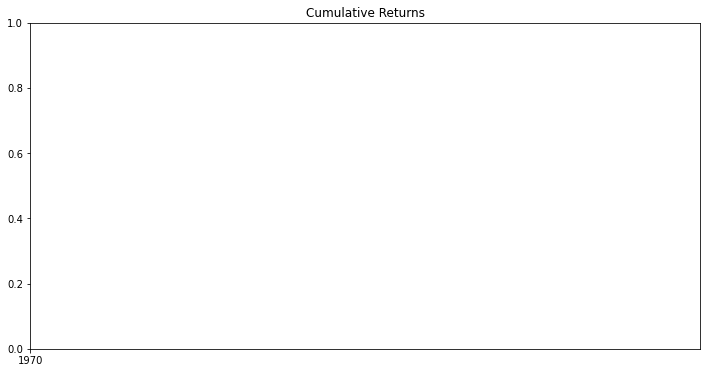

In [3]:
#plot cumulative profit of straddle dispersion & benchmark 

#plotting
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels

plt.figure(figsize=(12,6))
plt.title('Cumulative Returns')

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis


#plt.plot((1+pnl_straddle).cumprod(), label='PnL Straddle Implied Correlation entry')
plt.plot((1+df_vti_returns).cumprod(), label='VTI')
plt.plot((1+pnl_straddle_dis).cumprod(),label='Pnl straddle Dispersion Entry')
plt.plot((1+pnl_straddle).cumprod(),label='Pnl straddle Implied Correlation Entry')
#plt.plot((1+pnl_straddle_pairwise).cumprod(),label='Pnl straddle Pairwise correlation Entry')
plt.legend()
plt.savefig('../../Graphs/cumulative_returns.png')
plt.show()

In [ ]:
float((1+pnl_straddle).cumprod().iloc[-1].values-(1+df_vti_returns).cumprod().iloc[-1])

## Yearly returns

In [ ]:
(((1+pnl_straddle.mean())**252)-1)*100

In [ ]:
(((1+pnl_straddle_dis.mean())**252)-1)*100

## Sharpe Ratio

In [ ]:
def sharpe_ratio(rf,pnl_straddle):
    rf=np.mean(rf)
    rp=pnl_straddle.mean()*(252**0.5)
    sr=(rp-rf)/pnl_straddle.std()
    return sr

In [ ]:
#with rf of 10 years bond yield
sr_dis_rf=sharpe_ratio(df_tnx,pnl_straddle_dis)
sr_rf=sharpe_ratio(df_tnx,pnl_straddle)
sr_pair_rf=sharpe_ratio(df_tnx,pnl_straddle_dis_pair)

In [ ]:
#with rf of 0
sr_dis=sharpe_ratio(0,pnl_straddle_dis)
sr=sharpe_ratio(0,pnl_straddle)
sr_pair=sharpe_ratio(0,pnl_straddle_pair)

## CAPM

In [ ]:
reg_data=pd.concat([df_vti_returns,pnl_straddle_dis], axis=1).fillna(0.01)
lr=stats.linregress(reg_data.returns_dispersion,reg_data.returns)
beta,alpha,r_val,p_val,std_err = lr

In [ ]:
alpha

In [ ]:
beta

In [ ]:
p_val

In [ ]:
reg_data=pd.concat([df_vti_returns,pnl_straddle_dis], axis=1).fillna(0.01)
lr=stats.linregress(reg_data.returns_dispersion,reg_data.returns)
beta,alpha,r_val,p_val,std_err = lr

In [ ]:
alpha

## Tracking Error

In [ ]:
excess_return=reg_data.returns_dispersion-reg_data.returns
excess_return.plot()

In [ ]:
te=excess_return.std()
te

## Information Ratio

In [ ]:
ir=excess_return.mean()/te
ir

## Correlation

In [ ]:
reg_data=pd.concat([df_vti_returns,pnl_straddle_dis], axis=1).fillna(0.01)
reg_data.corr()

## Functions Temp

In [ ]:
def returns_portfolio_straddle(df_portfolio_straddle, enter, list_symbols,weights):
    profit_lost=pd.DataFrame()
    for row in range(len(enter)):
        try:
            df_filtered=pd.DataFrame()
            df_filter_onEntryDate=df_portfolio_straddle.loc[df_portfolio_straddle.EntryDate==enter.iloc[row].name.replace(tzinfo=None)]
            print(len(df_filter_onEntryDate))
            for security in list_symbols:
                df = df_filter_onEntryDate.loc[df_filter_onEntryDate.ticker==security]
                df_filtered[security]=(df.best_bid*df.straddle_weights).values            
            df_filtered.index=df.date
            df_filtered=df_filtered.groupby(df_filtered.index).mean()
            df_filtered= df_filtered.replace(0, 0.01)
            df_filtered= df_filtered.replace(-0.0,0.1)
            returns_df= df_filtered.pct_change()
            returns_df= returns_df.iloc[0:,:]
            returns_df= returns_df.fillna(0)
            returns_df= returns_df*weights.weights.tolist()
            returns_df= returns_df.mean(axis=1)
            profit_lost=pd.concat([profit_lost,returns_df])
        except:
            print(f"error in data with entry {enter.iloc[row].name}, missing data of: {security}")
    return profit_lost.groupby(profit_lost.index).mean()

In [ ]:
def portfolio_straddle(trade_book1,option_data):
    """


    Parameters
    ----------
    trade_book1 : TYPE
        DESCRIPTION.

    Returns
    -------
    df_portfolio : TYPE
        DESCRIPTION.

    """
    df_portfolio = pd.DataFrame()
    for row in range(len(trade_book1)):
        straddle_weights = trade_book1.straddle_weights.loc[row]
        optionid = trade_book1.optionid.loc[row]
        begin_date = trade_book1.date.loc[row]
        end_date = trade_book1.exit_date.loc[row]
        df=option_data.loc[option_data.optionid==optionid]
        df=df.loc[df.date>begin_date]
        df=df.loc[df.date<end_date]
        df['EntryDate']=begin_date
        df['optionid']=optionid
        df['straddle_weights']=straddle_weights
        df_portfolio= pd.concat([df_portfolio,df])

    return df_portfolio

In [ ]:
def missing_values(enter, df_portfolio,list_symbols):
    missing_values={'security': [], 'enter': [], 'date':[]}
    for row in range(len(enter)):
        df=df_portfolio.loc[df_portfolio.EntryDate==enter.iloc[row].name.replace(tzinfo=None)]
        for date in df.date.unique():
            df=df.loc[df.date==date]
            if len(df.ticker.tolist())!=len(list_symbols):
                for security in list_symbols:
                    if security not in df.ticker.tolist():
                        missing_values['security'].append(security)
                        missing_values['enter'].append(enter.iloc[row].name)
                        missing_values['date'].append(date)
    return pd.DataFrame(missing_values)  

In [ ]:
def add_missing_values(df_portfolio,df_missing_values):
    for index, row in df_missing_values.iterrows():
        df=df_portfolio.loc[df_portfolio.optionid==row.optionid]
        df=df.loc[df.ticker==row.security]
        print(df)    
    return df_portfolio

In [ ]:
def add_missing_values(df_portfolio,df_missing_values):
    for index, row in df_missing_values.iterrows():
        df=df_portfolio.loc[df_portfolio.EntryDate==row.enter]
        df=df.loc[df.ticker==row.security]
        print(df)
        
    return df_portfolio